# 0_Impact_of_Censoring_and_Truncating_on_the_Estimator

This notebook demostrates the impact of the censoring and truncation on the Linear Bayesian Regression.


In [119]:
!pip install -q pyro-ppl

In [120]:
import os
from functools import partial

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

import numpy as np

import pyro
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Regression Model
* generate data for the regression model

In [122]:
N = 500
slope = 1.
true_sigma = 2.0
intercept = 1.


# generate the data
X = dist.Uniform(torch.tensor([-10.]), torch.tensor([10.0]))
eps = dist.Normal(torch.Tensor([0]), torch.Tensor([true_sigma]))

x = X.sample(sample_shape=(N,))
noise = eps.sample(sample_shape=(N,))
y = intercept + slope * x + noise

# censor the data
lower_bound = -4.
upper_bound = 4.

y_censored = torch.clamp(y, min=lower_bound, max=upper_bound)
mask = (y < lower_bound)  | (y > upper_bound)
y_censored_indices = torch.nonzero(mask, as_tuple=True)[0]
y_truncated_indices = torch.nonzero(~mask, as_tuple=True)[0]

x_truncated = x[y_truncated_indices]
y_truncated = y[y_truncated_indices]

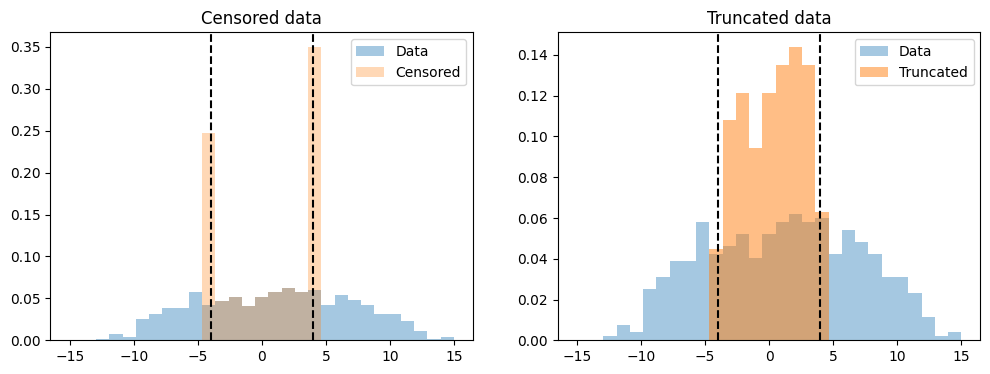

In [123]:
# Visualize uncensored, censored and truncated data
_, ax = plt.subplots(1,2, figsize=(12, 4))
edges = np.linspace(-15, 15, 30)
for ax_ in ax:
  ax_.hist(y.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.4, label="Data")
  [ax_.axvline(x=x, c="k", ls="--") for x in [lower_bound, upper_bound]]

ax[0].hist(y_censored.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.3, label="Censored")
ax[0].legend()
_ = ax[0].set(title="Censored data")

ax[1].hist(y_truncated.numpy(), bins=edges, density=True, histtype="stepfilled", alpha=0.5, label="Truncated")
ax[1].legend()
_ = ax[1].set(title="Truncated data")


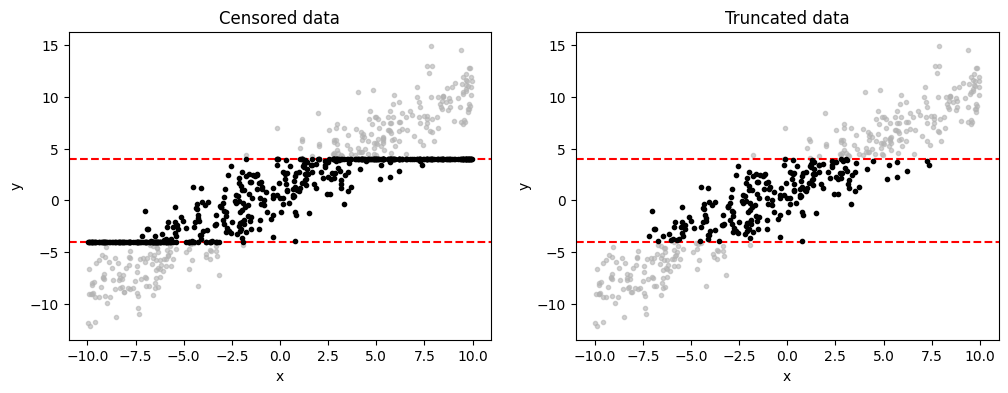

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax_ in ax:
  ax_.plot(x, y, ".", alpha=0.6, c=[0.7, 0.7, 0.7])
  ax_.axhline(lower_bound, c='red', ls="--")
  ax_.axhline(upper_bound, c='red', ls="--")
  ax_.set(xlabel="x", ylabel="y")

ax[0].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black')
_ = ax[0].set(title="Censored data")
ax[1].plot(x_truncated.numpy(), y_truncated.numpy(), ".", c='black')
_ = ax[1].set(title="Truncated data")

### Linear Regression

In [125]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)  # Single input feature, single output

    def forward(self, x):
        return self.linear(x)

def optimise_lin_reg(model, x, y, num_iterations=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    loss_fn = torch.nn.MSELoss(reduction='sum')

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        optimizer.zero_grad()
        y_pred = model(x) #forward pass
        loss = loss_fn(y_pred, y)
        loss.backward()
        # take a gradient step
        optimizer.step()
        losses.append(loss.item())
    res = {
        'model': model,
        'losses' : losses
        }
    for name, param in model.named_parameters():
      print(name, param.data.numpy())
    return res

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

def train_and_predict(x, y, steps):
  model_ = LinearRegressionModel(1, 1)
  trained_ = optimise_lin_reg(model_, x, y, steps)
  y_pred = trained_['model'](x).detach().cpu().numpy()
  return {'model': trained_['model'],
          'losses' :  trained_['losses'],
          'y_pred': y_pred

  }

In [126]:
lm_all_data = train_and_predict(x, y, 5000)
lm_trunc = train_and_predict(x_truncated, y_truncated, 5000)
lm_cens = train_and_predict(x, y_censored, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

linear.weight [[0.98681009]]
linear.bias [1.04892854]


  0%|          | 0/5000 [00:00<?, ?it/s]

linear.weight [[0.58221995]]
linear.bias [0.77623405]


  0%|          | 0/5000 [00:00<?, ?it/s]

linear.weight [[0.53599436]]
linear.bias [0.49989213]


In [127]:
y_pred = lm_all_data['y_pred']
y_censored_pred = lm_cens['y_pred']
y_truncated_pred = lm_trunc['y_pred']

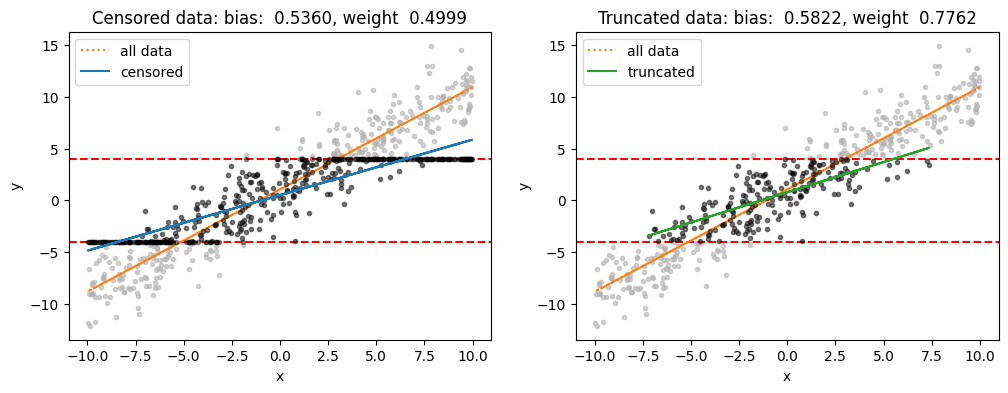

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for ax_ in ax:
  ax_.plot(x, y, ".", alpha=0.6, c=[0.7, 0.7, 0.7])
  ax_.axhline(lower_bound, c='red', ls="--")
  ax_.axhline(upper_bound, c='red', ls="--")
  ax_.set(xlabel="x", ylabel="y")

ax[0].plot(x, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
ax[1].plot(x, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
ax[0].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black', alpha=0.4)
_ = ax[0].set(title="Censored data: bias: {: .4f}, weight {: .4f}".format(lm_cens['model'].linear.weight.item(), lm_cens['model'].linear.bias.item()))
ax[0].plot(x, y_censored_pred, color=sns.color_palette()[0], label='censored')
ax[1].plot(x_truncated.numpy(), y_truncated.numpy(), ".", c='black', alpha=0.4)
ax[1].plot(x_truncated, y_truncated_pred, color=sns.color_palette()[2], label='truncated')
_ = ax[1].set(title="Truncated data: bias: {: .4f}, weight {: .4f}".format(lm_trunc['model'].linear.weight.item(), lm_trunc['model'].linear.bias.item()))

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

### Bayessian Regression

In [129]:
# set path for importing scripts
import sys
sys.path.append('/content/drive/MyDrive/transfer_viva/icml2024/src')

import importlib
import censored_normal
importlib.reload(censored_normal)

from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO

In [130]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.HalfNormal(1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

class BayesianRegressionCensored(PyroModule):
    def __init__(self, in_features, out_features, low, high):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))
        self.low = low
        self.high = high

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.HalfNormal(1.))
        mean = self.linear(x).squeeze(-1)
        low = torch.Tensor([self.low])
        high = torch.Tensor([self.high])
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", censored_normal.PyroCensoredNormal(mean, sigma, low, high), obs=y)
        return mean


def optimise_bayes_lin_reg(model, guide, x, y, num_iterations=1000):
    pyro.clear_param_store()
    optimizer = pyro.optim.Adam({'lr': 0.05})
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    svi = SVI(model, guide, optimizer, loss=loss_fn)

    pbar = tqdm(range(num_iterations), position=0, leave=True)

    losses = []
    for epoch in pbar:
        loss = svi.step(x, y)
        losses.append(loss)

    res = {
        'model': model,
        'guide': guide,
        'losses': losses
        }
    return res


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

def train_and_predict_bayes(x, y, x_test, steps, censored=False, lower_bound=None, upper_bound=None):
  pyro.clear_param_store()
  if censored==True:
    model_ = BayesianRegressionCensored(1, 1, lower_bound, upper_bound)
  else:
    model_ = BayesianRegression(1, 1)
  guide_ = AutoDiagonalNormal(model_) # posterior approximation

  trained_ = optimise_bayes_lin_reg(model_, guide_, x, y, steps)
  predictive_y = Predictive(model_, guide=guide_, num_samples=500)
  samples_ = predictive_y(torch.Tensor(x_test))

  pred_summary = summary(samples_)
  y_predicted = pred_summary["obs"]
  weights_predicted = pred_summary["linear.weight"]

  y_pred = y_predicted['mean']
  y_perc_5 = y_predicted["5%"]
  y_perc_95 = y_predicted["95%"]


  return {'model': trained_,
          'guide': guide_,
          'samples': samples_,
          'y_pred': y_predicted['mean'],
          'y_perc_5': y_predicted["5%"],
          'y_perc_95': y_predicted["95%"]
  }

x_ = lambda x: torch.Tensor(x.numpy())
y_ = lambda y: torch.Tensor(y.squeeze().numpy())

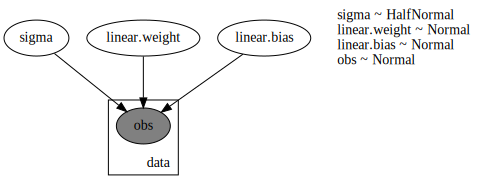

In [131]:
model_ = BayesianRegression(1, 1)
guide_ = AutoDiagonalNormal(model_) # posterior approximation
pyro.render_model(model_, model_args=(x, y), render_distributions=True, render_params=True)

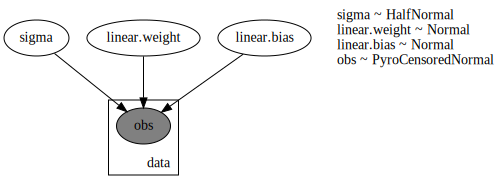

In [132]:
model_ = BayesianRegressionCensored(1, 1, lower_bound, upper_bound)
guide_ = AutoDiagonalNormal(model_) # posterior approximation
pyro.render_model(model_, model_args=(x, y), render_distributions=True, render_params=True)

In [133]:
x_test = torch.linspace(-15, 15, 500).reshape(500, 1)
bm_all_data = train_and_predict_bayes(x_(x), y_(y), x_test, steps=10000, censored=False, lower_bound=None, upper_bound=None)
bm_trunc = train_and_predict_bayes(x_(x_truncated), y_(y_truncated), x_test, steps=10000, censored=False, lower_bound=None, upper_bound=None)
bm_censored = train_and_predict_bayes(x_(x), y_(y_censored), x_test, steps=10000, censored=False, lower_bound=None, upper_bound=None)
bmc_censored = train_and_predict_bayes(x_(x), y_(y_censored), x_test, steps=10000, censored=True, lower_bound=lower_bound, upper_bound=upper_bound)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [134]:
dict_list = [bm_all_data, bm_trunc, bm_censored, bmc_censored]
str_list = ['', 'truncated_', 'censored_', 'censored2_']
str_ = str_list[0]
keys_ = ['y_{}pred'.format(str_), 'y_{}perc_5'.format(str_), 'y_{}perc_95'.format(str_)]
model_keys_ = ['y_pred', 'y_perc_5', 'y_perc_95']

In [135]:
dict_plot = {}
for model, label in zip(dict_list, str_list):
  str_ = label
  keys_ = ['y_{}pred'.format(str_), 'y_{}perc_5'.format(str_), 'y_{}perc_95'.format(str_)]
  for key_, var_ in zip(model_keys_, keys_):
    dict_plot[var_] = model[key_]

dict_plot['x'] = x
dict_plot['y'] = y
dict_plot['x_test'] = x_test.squeeze()

In [136]:
dict_plot_params = {}

for idx, model in enumerate(dict_list):
  for key_ in ['samples', 'guide']:
    dict_plot_params['{}{}'.format(key_, idx+1)] = model[key_]

In [137]:
def plot(x, y, x_test, y_pred, y_perc_5, y_perc_95, y_censored_pred, y_censored_perc_5, y_censored_perc_95, y_censored2_pred, y_censored2_perc_5, y_censored2_perc_95, y_truncated_pred, y_truncated_perc_5, y_truncated_perc_95):
  fig, ax = plt.subplots(1, 4, figsize=(18, 4))

  for ax_ in ax:
    ax_.plot(x.squeeze().numpy(), y.squeeze().numpy(), ".", alpha=0.6, c=[0.7, 0.7, 0.7])
    ax_.axhline(lower_bound, c='red', ls="--")
    ax_.axhline(upper_bound, c='red', ls="--")
    ax_.set(xlabel="x", ylabel="y")


  _ = ax[0].set(title="All data")
  ax[0].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black', alpha=0.4)
  ax[0].plot(x_test, y_pred, color=sns.color_palette()[1], label='all data ')
  ax[0].fill_between(x_test, y_perc_5, y_perc_95, alpha=0.1, color=sns.color_palette()[1])

  ax[1].plot(x_test, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
  ax[1].fill_between(x_test, y_perc_5, y_perc_95, alpha=0.1, color=sns.color_palette()[1])

  _ = ax[1].set(title="Truncated data")
  ax[1].plot(x_truncated.numpy(), y_truncated.numpy(), ".", c='black', alpha=0.4)
  ax[1].plot(x_test, y_truncated_pred, color=sns.color_palette()[2], label='truncated')
  ax[1].fill_between(x_test, y_truncated_perc_5, y_truncated_perc_95, alpha=0.3, color=sns.color_palette()[2])

  ax[2].plot(x_test, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
  ax[2].fill_between(x_test, y_perc_5, y_perc_95, alpha=0.1, color=sns.color_palette()[1])

  _ = ax[2].set(title="Censored data")
  ax[2].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black', alpha=0.4)
  ax[2].plot(x_test, y_censored_pred, color=sns.color_palette()[0], label='censored')
  ax[2].fill_between(x_test, y_censored_perc_5, y_censored_perc_95, alpha=0.1, color=sns.color_palette()[0])


  ax[3].plot(x_test, y_pred, color=sns.color_palette()[1], ls=":", label='all data')
  ax[3].fill_between(x_test, y_perc_5, y_perc_95, alpha=0.1, color=sns.color_palette()[1])

  _ = ax[3].set(title="Censored data - CensoredNormal")
  ax[3].plot(x.squeeze().numpy(), y_censored.numpy(), ".", c='black', alpha=0.4)
  ax[3].plot(x_test, y_censored2_pred, color=sns.color_palette()[3], label='censored normal posterior')
  ax[3].fill_between(x_test, y_censored2_perc_5, y_censored2_perc_95, alpha=0.1, color=sns.color_palette()[3])


  ax[0].legend(loc='upper left')
  ax[1].legend(loc='upper left')
  ax[2].legend(loc='upper left')
  ax[3].legend(loc='upper left')

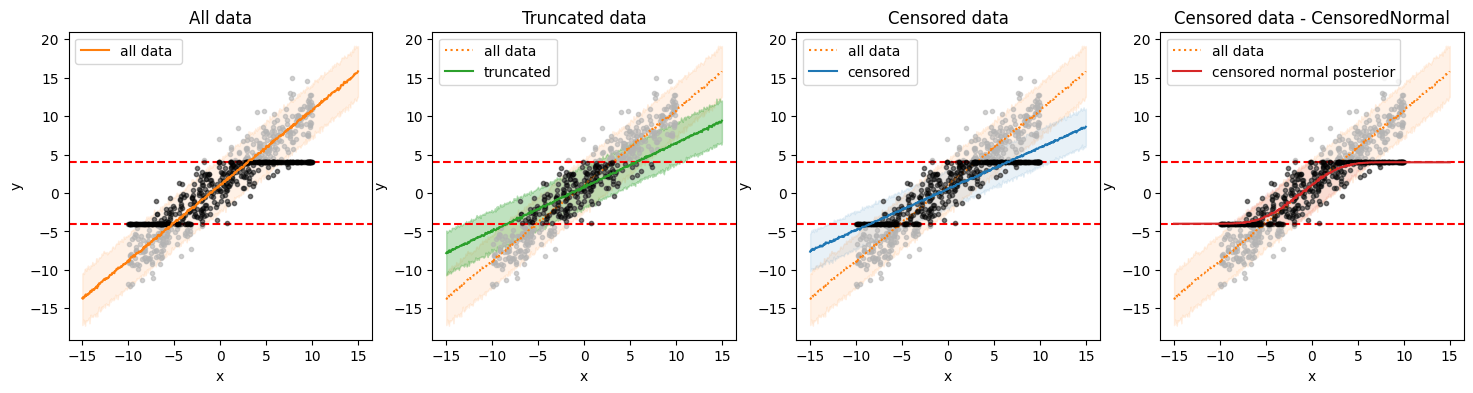

In [138]:
plot(**dict_plot)

#### Posteriors Investigation

In [139]:
def visualise_posterior(param_, samples1, guide1, samples2, guide2, samples3, guide3, samples4, guide4):
  _, ax = plt.subplots(1,4, figsize=(20, 4))
  ax[0].hist(samples1[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[1], label="all data")
  [ax[0].axvline(x=x, c="grey", ls="--") for x in guide1.quantiles([0.05, 0.95])[param_].squeeze()]
  _ = ax[0].set(title="all data - {}: \nmean {: .4f}, std {: .4f}".format(param_,
      samples1[param_].squeeze().mean(), samples1[param_].squeeze().std()))

  ax[1].hist(samples2[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[0],  label="truncated")
  [ax[1].axvline(x=x, c="grey", ls="--") for x in guide2.quantiles([0.05, 0.95])[param_].squeeze()]
  _ = ax[1].set(title="truncated - {}: \nmean {: .4f}, std {: .4f}".format(param_,
      samples2[param_].squeeze().mean(), samples2[param_].squeeze().std()))

  ax[2].hist(samples3[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[2], label="censored - normal posterior")
  [ax[2].axvline(x=x, c="grey", ls="--") for x in guide3.quantiles([0.05, 0.95])[param_].squeeze()]
  _ = ax[2].set(title="censored - wrong posterior - {}: \nmean {: .4f}, std {: .4f} ".format(param_,
    samples3[param_].squeeze().mean(), samples3[param_].squeeze().std()))

  ax[3].hist(samples4[param_].squeeze(), density=True, bins=30, alpha=0.4, color=sns.color_palette()[3], label="censored - censored normal posterior")
  [ax[3].axvline(x=x, c="grey", ls="--") for x in guide4.quantiles([0.05, 0.95])[param_].squeeze()]
  _ = ax[3].set(title="censored - correct posterior - {}: \nmean {: .4f}, std {: .4f} ".format(param_,
    samples4[param_].squeeze().mean(), samples4[param_].squeeze().std()))
  plt.show()

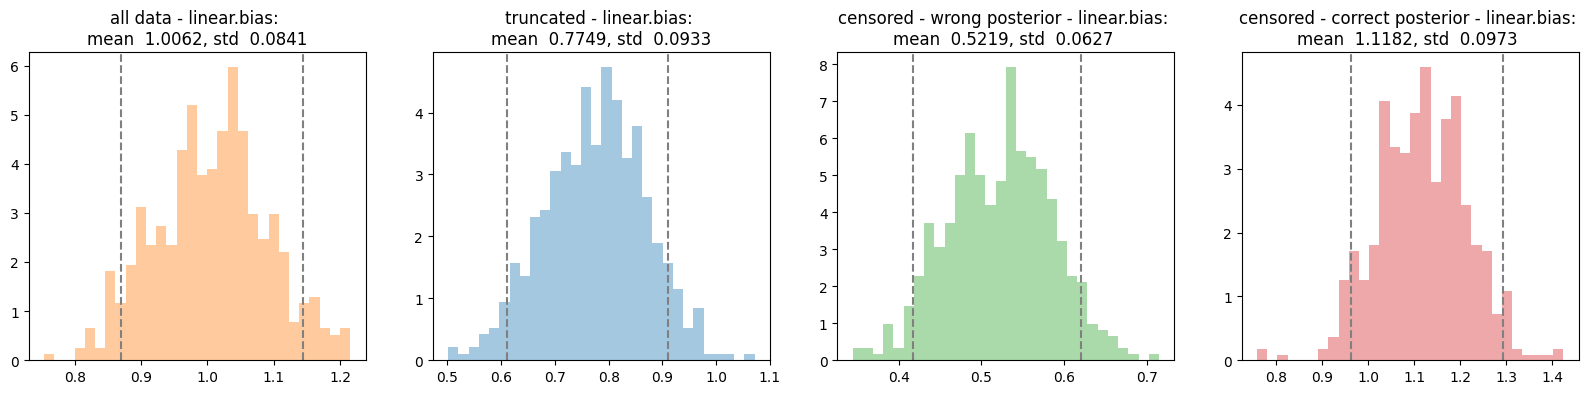

In [140]:
visualise_posterior('linear.bias', **dict_plot_params)

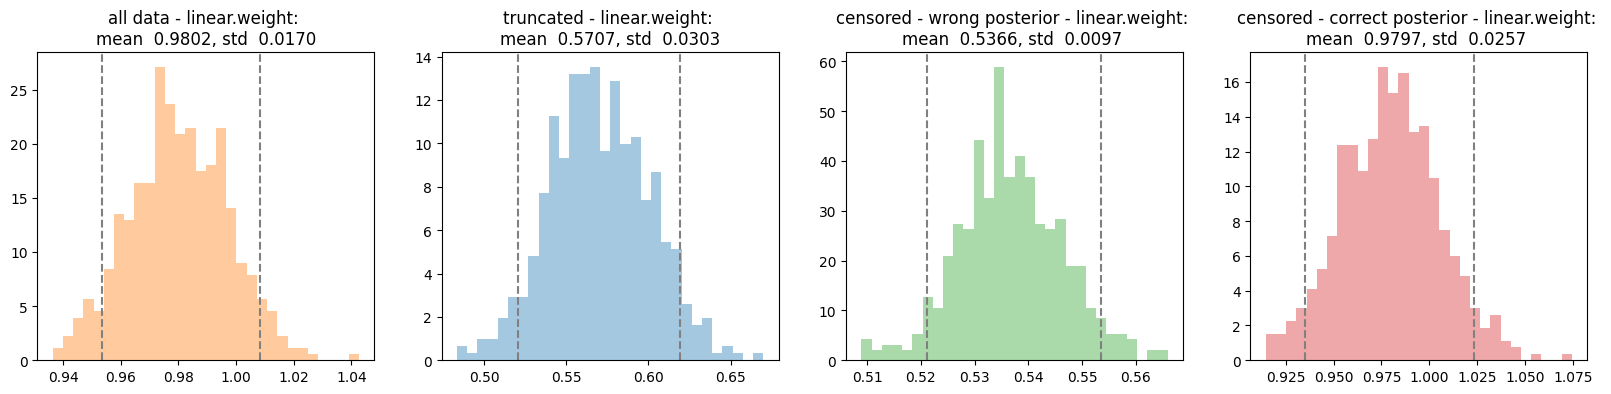

In [141]:
visualise_posterior('linear.weight', **dict_plot_params)

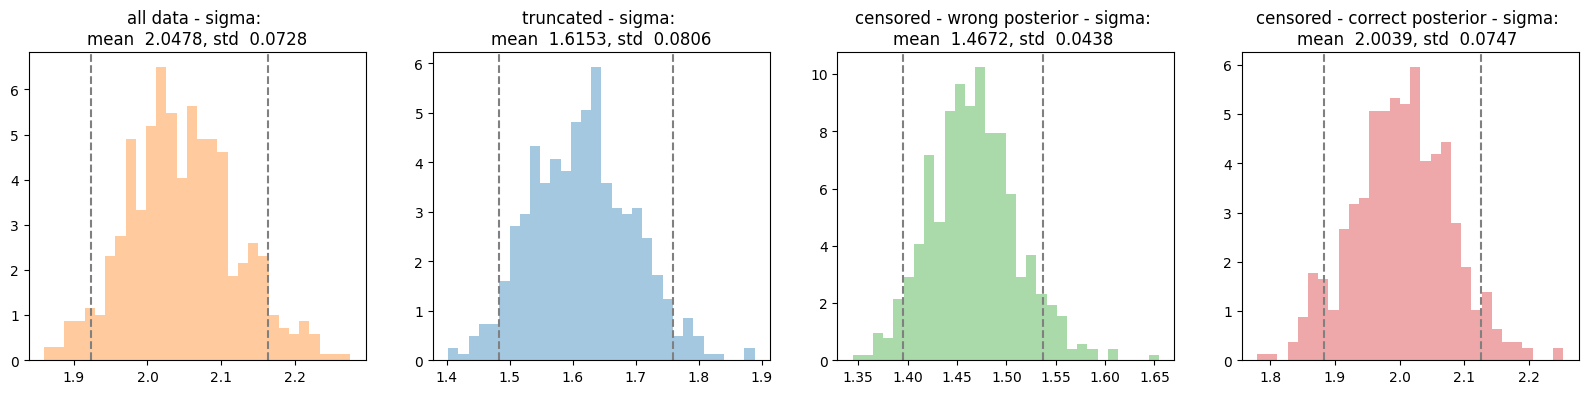

In [142]:
visualise_posterior('sigma', **dict_plot_params)

In [143]:
#predictive_y_prior = pyro.infer.Predictive(model_, {}, num_samples=500)